# Лабораторная работа №5

Бирюков В. В.

Группа: М8О-407Б-19

## Setup

In [1]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

import torch
from yolov5 import utils
from utils.plots import plot_results
display = utils.notebook_init()  # checks
%cd ..

YOLOv5 🚀 v7.0-131-g0c8de3f Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 25.6/78.2 GB disk)
/content


## Загрузка данных

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q /content/drive/MyDrive/tensorflow-great-barrier-reef.zip

## Подготовка данных

In [27]:
!mv train_images barrier_reef

!mv barrier_reef/video_0 barrier_reef/train
!mkdir barrier_reef/train/images
!mv barrier_reef/train/*.jpg barrier_reef/train/images

!mkdir barrier_reef/val
!mkdir barrier_reef/val/images
!mkdir barrier_reef/val/labels

In [9]:
import pandas as pd
from pathlib import Path
from PIL import Image
from random import shuffle

In [29]:
labels = pd.read_csv('train.csv')

In [30]:
root = Path('barrier_reef')
train_images = root / 'train/images'
train_labels = root / 'train/labels'
train_labels.mkdir(exist_ok=True)

val_images = root / 'val/images'
val_labels = root / 'val/labels'

In [31]:
def gen_labels(images_path, labels_path, video_id, keep_empty_images=False):
    for _, row in labels[labels['video_id'] == video_id].iterrows():
        image = images_path / f'{row["video_frame"]}.jpg'

        if not image.exists():
            continue

        if row['annotations'] == '[]':
            if not keep_empty_images:
                image.unlink(missing_ok=True)
            continue

        boxes = eval(row['annotations'])

        with Image.open(image) as im:
            width = im.width
            height = im.height

        with open(labels_path / f'{row["video_frame"]}.txt', 'wt') as f:
            for b in boxes:
                f.write(f"0 {(b['x'] + b['width'] / 2) / width} {(b['y'] + b['height'] / 2) / height} {b['width'] / width} {b['height'] / height}\n")

In [32]:
# Генерация файлов с разметкой. Изображения без объектов удаляются
gen_labels(train_images, train_labels, 0)

In [33]:
# Всего изображений 2143, оставим 2000 для обучения, остальное -- для валидации
frames = !ls -1 {train_images}
shuffle(frames)

for frame in frames[2000:]:
    (train_images / frame).rename(val_images / frame)
    (train_labels / frame).with_suffix('.txt').rename((val_labels / frame).with_suffix('.txt'))

In [14]:
%%writefile barrier_reef.yaml
path: /content/barrier_reef
train: train/images
val: val/images
test:

nc: 1
names: [ 'starfish' ]

Writing barrier_reef.yaml


## Обучение

In [34]:
# Обучаем 30 эпох со стандратными настройками
!python yolov5/train.py --img 640 --batch 16 --epochs 30 --data barrier_reef.yaml --weights yolov5s.pt --cache

train: weights=yolov5s.pt, cfg=, data=barrier_reef.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-131-g0c8de3f Python-3.9.16 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv

## Результаты

In [12]:
results = Path('yolov5/runs/train/exp4')

История обучения. Из конечных значений метрик следует, что 2% морских звезд на распознаются, 2% распознаются ошибочно

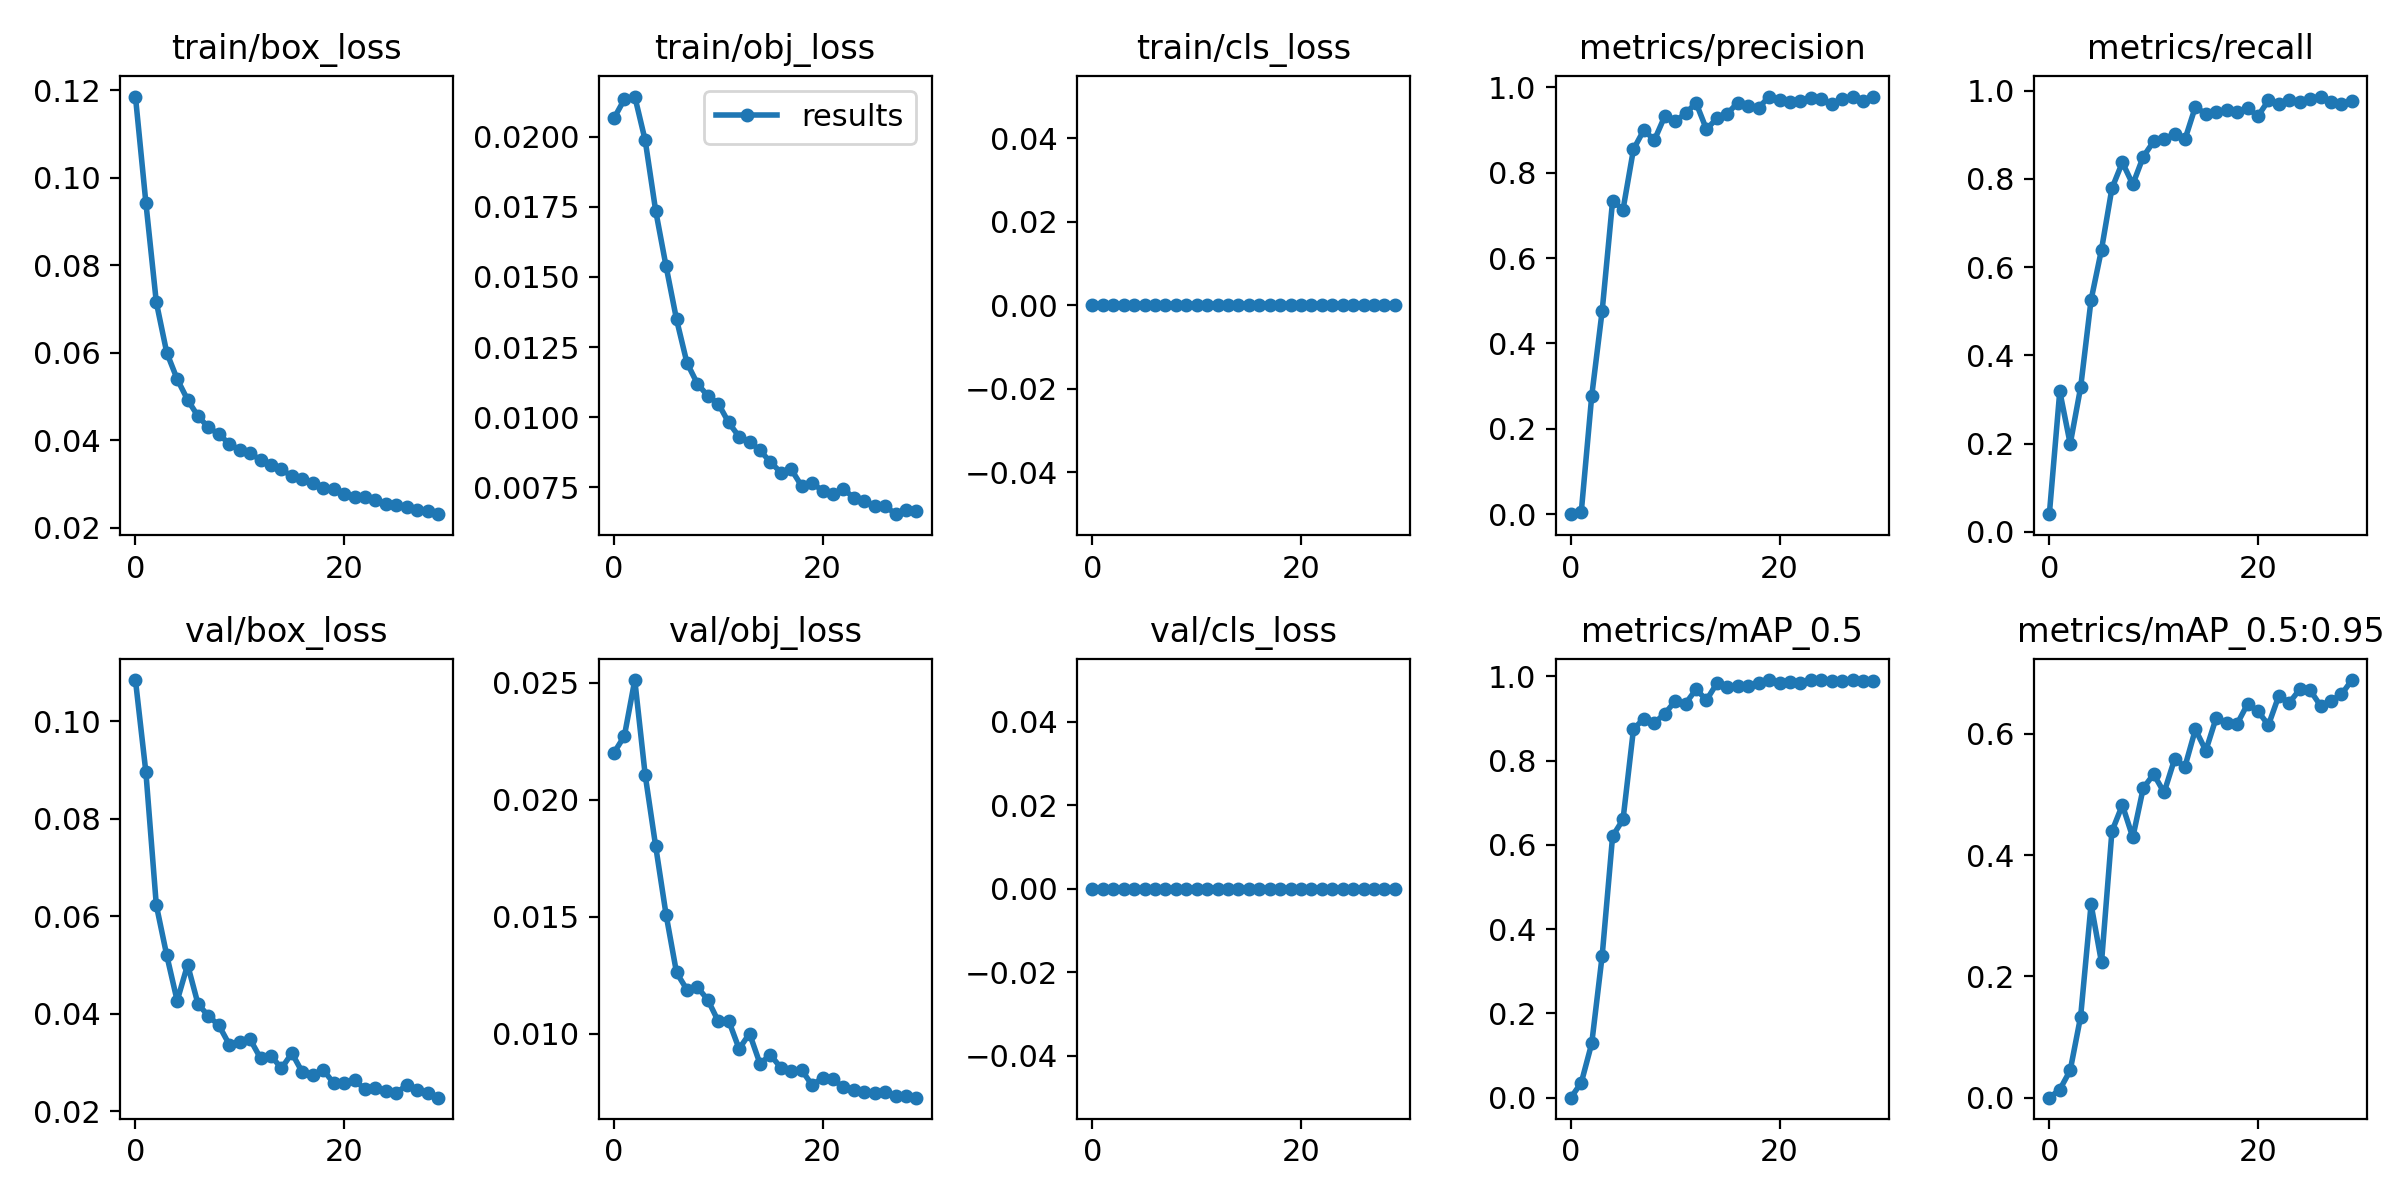

In [36]:
plot_results(results / 'results.csv')
display.Image(filename=results / 'results.png', width=1000)

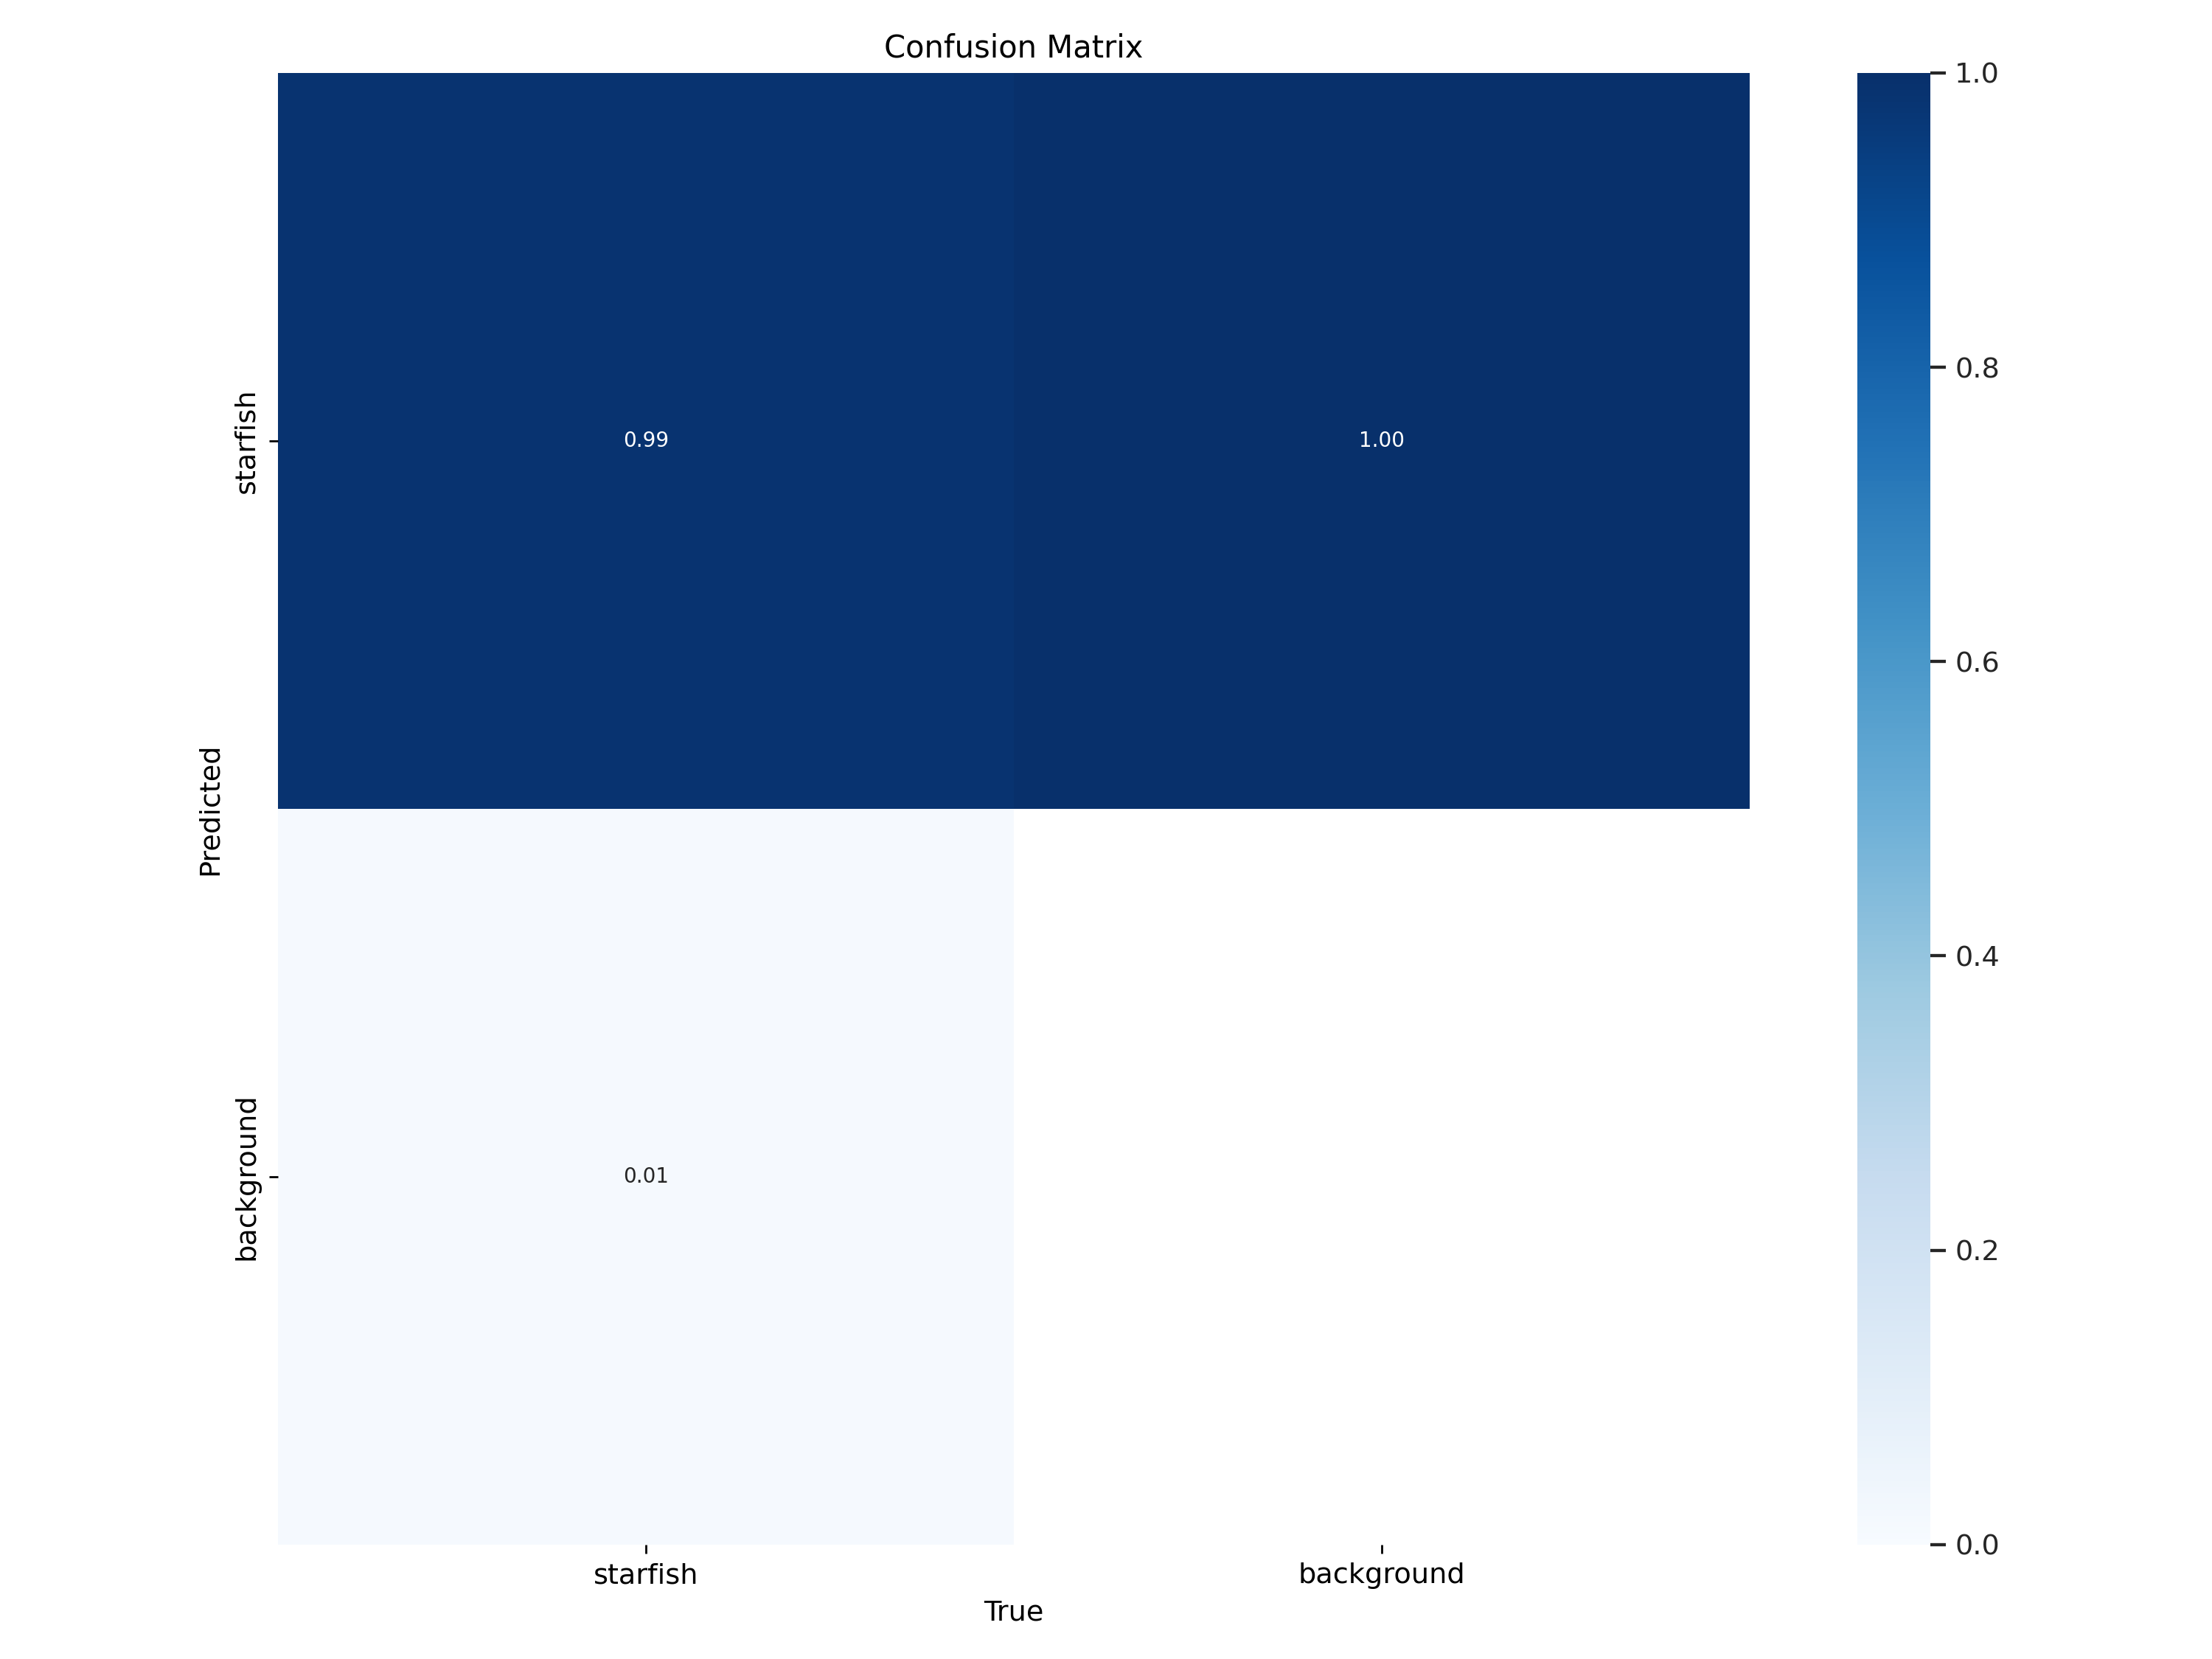

In [37]:
display.Image(filename=results / 'confusion_matrix.png', width=500)

In [16]:
import matplotlib.pyplot as plt

def plot_image(ax, image, interp='nearest'):    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(image)

Примеры тренировочных данных:

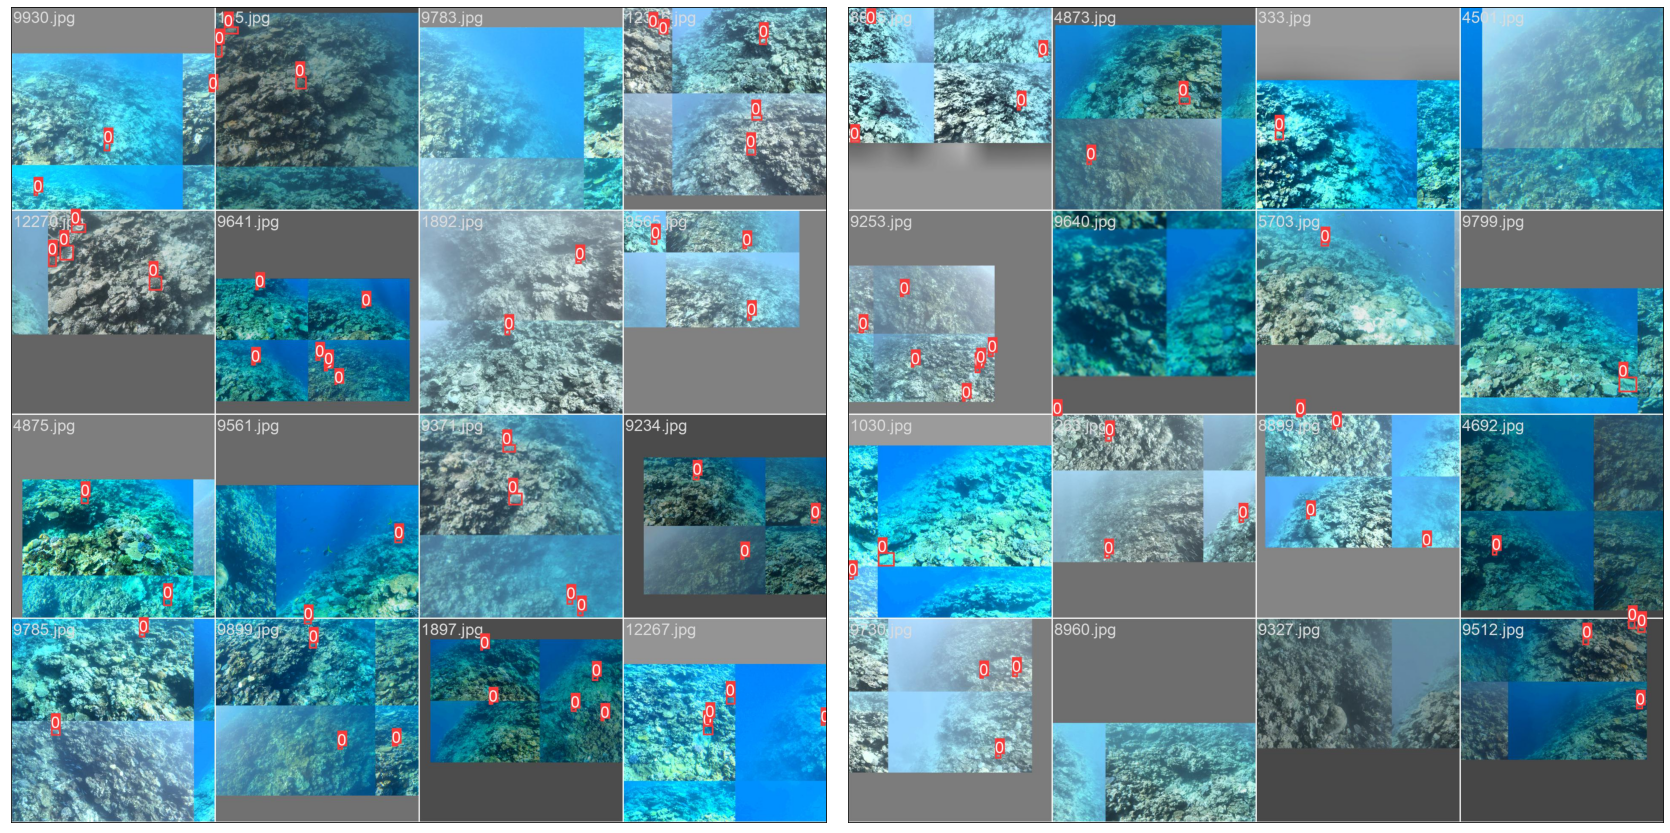

In [24]:
with Image.open(results / "train_batch0.jpg") as im1, Image.open(results / "train_batch1.jpg") as im2:
    fig = plt.figure(figsize=(30, 15))
    ax = fig.subplots(1, 2)
    plot_image(ax[0], im1)
    plot_image(ax[1], im2)
    fig.subplots_adjust(wspace=0)
    plt.show()

Примеры предсказаний на валидационной выборке:

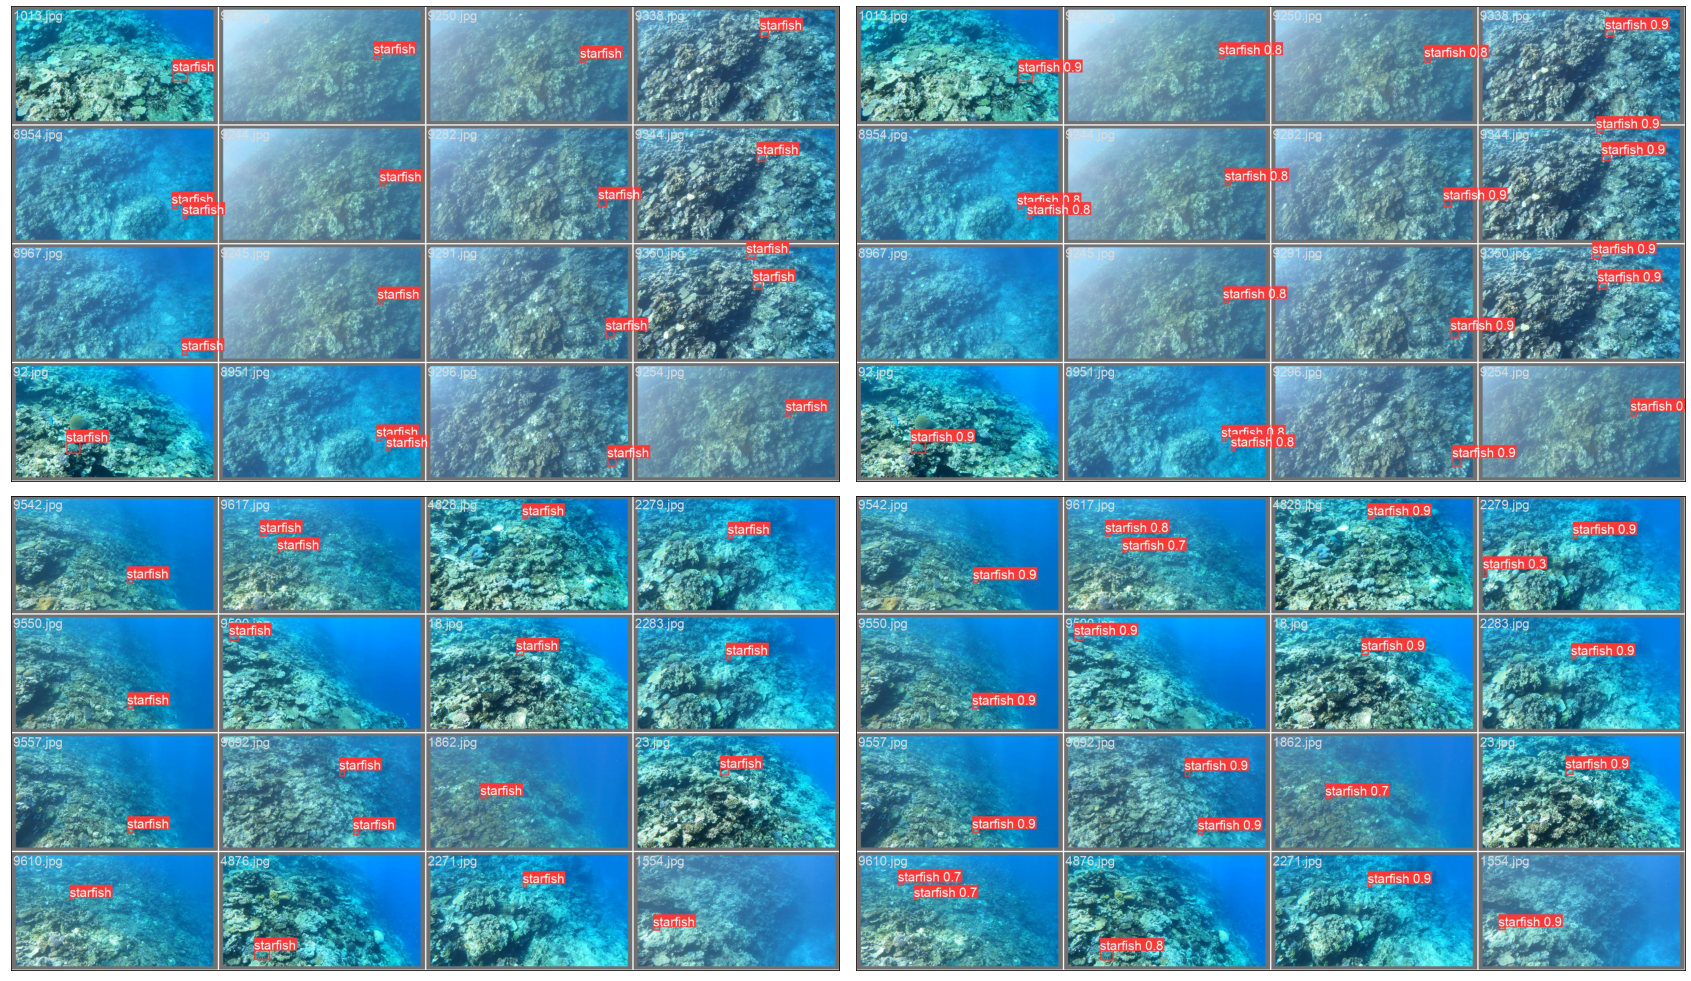

In [33]:
with Image.open(results / "val_batch0_labels.jpg") as im1, Image.open(results / "val_batch0_pred.jpg") as im2, \
     Image.open(results / "val_batch2_labels.jpg") as im3, Image.open(results / "val_batch2_pred.jpg") as im4:
    fig = plt.figure(figsize=(30, 18))
    ax = fig.subplots(2, 2)
    plot_image(ax[0, 0], im1)
    plot_image(ax[0, 1], im2)
    plot_image(ax[1, 0], im3)
    plot_image(ax[1, 1], im4)
    fig.subplots_adjust(hspace=0, wspace=0.02)
    plt.show()